# Zillow Regression Project: Estimating Home Value

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# set seaborn color palette
sns.color_palette("Paired")
pal = sns.set_palette('Paired')

# import models
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor, LogisticRegression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, normalize, StandardScaler

from sklearn.feature_selection import SelectKBest, f_regression, RFE

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

#import custom functions
import acquire
import explore
import wrangle



# Acquire & Prepare Data for Modeling

#### Using wrangle.py, call acquire.py to query data from SQL Zillow database and return a cleaned dataframe. 

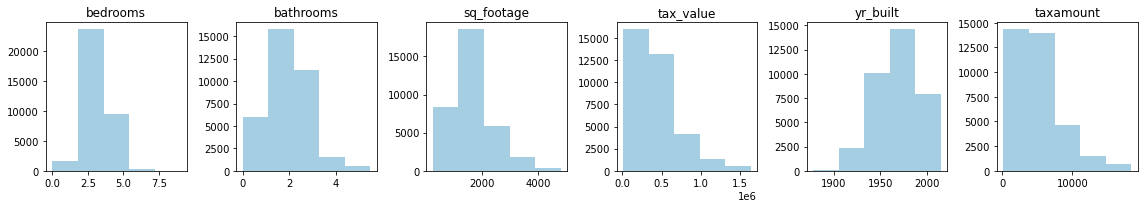

In [2]:
df = wrangle.wrangle_zillow()

In [3]:
#Look at the data returned
df.head()

bedrooms  bathrooms  sq_footage  tax_value  yr_built  taxamount    fips  \
0       3.0        2.0      1125.0   289445.0    1974.0    3490.16  6059.0   
1       3.0        2.0      1316.0   205123.0    1923.0    2627.48  6037.0   
2       3.0        2.0      1458.0   136104.0    1970.0    2319.90  6037.0   
3       3.0        2.0      1766.0   810694.0    1980.0    9407.01  6037.0   
4       2.0        1.0      1421.0    35606.0    1911.0     543.69  6037.0   

   propertylandusetypeid        propertylandusedesc  tax_rate       county  \
0                  266.0                Condominium  0.012058       Orange   
1                  261.0  Single Family Residential  0.012809  Los Angeles   
2                  261.0  Single Family Residential  0.017045  Los Angeles   
3                  266.0                Condominium  0.011604  Los Angeles   
4                  261.0  Single Family Residential  0.015270  Los Angeles   

        state  
0  California  
1  California  
2  California  
3  California  
4  California

In [4]:
df.shape

(35078, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35078 entries, 0 to 38557
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bedrooms               35078 non-null  float64
 1   bathrooms              35078 non-null  float64
 2   sq_footage             35078 non-null  float64
 3   tax_value              35078 non-null  float64
 4   yr_built               35078 non-null  float64
 5   taxamount              35078 non-null  float64
 6   fips                   35078 non-null  float64
 7   propertylandusetypeid  35078 non-null  float64
 8   propertylandusedesc    35078 non-null  object 
 9   tax_rate               35078 non-null  float64
 10  county                 35078 non-null  object 
 11  state                  35078 non-null  object 
dtypes: float64(9), object(3)
memory usage: 3.5+ MB


In [6]:
#Check to see if nulls were removed
df.isna().sum()

bedrooms                 0
bathrooms                0
sq_footage               0
tax_value                0
yr_built                 0
taxamount                0
fips                     0
propertylandusetypeid    0
propertylandusedesc      0
tax_rate                 0
county                   0
state                    0
dtype: int64

In [7]:
#Check to see if duplicates were removed
df[df.duplicated()]

Empty DataFrame
Columns: [bedrooms, bathrooms, sq_footage, tax_value, yr_built, taxamount, fips, propertylandusetypeid, propertylandusedesc, tax_rate, county, state]
Index: []

In [8]:
print("Mean of bedrooms:",df.bedrooms.mean())
print("Mean of bathrooms:", df.bathrooms.mean())
print("Mean of square footage:",df.sq_footage.mean())
print("Mean of tax value : ", df.tax_value.mean())
print("Mean of yr built:", df.yr_built.mean())
print("Mean of tax amount:", df.taxamount.mean())

Mean of bedrooms: 2.9710359769656196
Mean of bathrooms: 2.20698158389874
Mean of square footage: 1669.5460687610469
Mean of tax value :  421052.3798107076
Mean of yr built: 1969.2841952220765
Mean of tax amount: 5099.542507554598


In [9]:
# Look at the min and max of each feature
df.apply(wrangle.minMax)

bedrooms  bathrooms  sq_footage  tax_value  yr_built  taxamount    fips  \
min       0.0        0.0       240.0    11089.0    1878.0     138.54  6037.0   
max       9.0        5.5      4800.0  1634459.0    2015.0   18389.94  6111.0   

     propertylandusetypeid propertylandusedesc  tax_rate       county  \
min                  261.0        Cluster Home  0.006222  Los Angeles   
max                  266.0           Townhouse  0.018852      Ventura   

          state  
min  California  
max  California

array([[<AxesSubplot:title={'center':'fips'}>]], dtype=object)

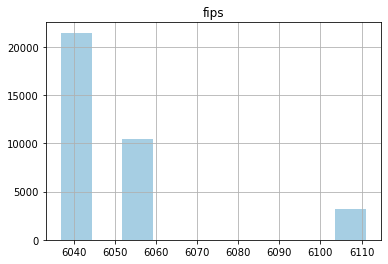

In [10]:
#See what the distribution of fips, or unique county codes, are
df.hist('fips')

In [11]:
df.fips.value_counts()

6037.0    21469
6059.0    10420
6111.0     3189
Name: fips, dtype: int64

array([[<AxesSubplot:title={'center':'propertylandusetypeid'}>]],
      dtype=object)

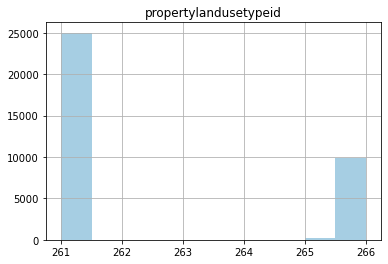

In [12]:
df.hist('propertylandusetypeid')

In [13]:
df.propertylandusetypeid.value_counts()

261.0    25008
266.0     9858
265.0      181
263.0       28
264.0        3
Name: propertylandusetypeid, dtype: int64

In [14]:
df.bathrooms.value_counts()

2.0    15018
3.0     7724
1.0     6000
2.5     3544
4.0     1029
1.5      740
3.5      508
4.5      243
5.0      215
5.5       32
0.0       25
Name: bathrooms, dtype: int64

In [15]:
df.bedrooms.value_counts()

3.0    14373
2.0     9297
4.0     7796
5.0     1664
1.0     1583
6.0      205
0.0      134
7.0       21
8.0        4
9.0        1
Name: bedrooms, dtype: int64

In [16]:
df.sq_footage.mean()

1669.5460687610469

In [17]:
df.sq_footage.min()

240.0

In [18]:
df.sq_footage.max()

4800.0

In [19]:
df.shape

(35078, 12)

In [20]:
#Confirming that the tax rate was created for each property and add it to the dataframe in wrangle.py


In [21]:
#Confirming that a new column was created identifying the county for each property and add it to the dataframe 
df.head()

bedrooms  bathrooms  sq_footage  tax_value  yr_built  taxamount    fips  \
0       3.0        2.0      1125.0   289445.0    1974.0    3490.16  6059.0   
1       3.0        2.0      1316.0   205123.0    1923.0    2627.48  6037.0   
2       3.0        2.0      1458.0   136104.0    1970.0    2319.90  6037.0   
3       3.0        2.0      1766.0   810694.0    1980.0    9407.01  6037.0   
4       2.0        1.0      1421.0    35606.0    1911.0     543.69  6037.0   

   propertylandusetypeid        propertylandusedesc  tax_rate       county  \
0                  266.0                Condominium  0.012058       Orange   
1                  261.0  Single Family Residential  0.012809  Los Angeles   
2                  261.0  Single Family Residential  0.017045  Los Angeles   
3                  266.0                Condominium  0.011604  Los Angeles   
4                  261.0  Single Family Residential  0.015270  Los Angeles   

        state  
0  California  
1  California  
2  California  
3  California  
4  California

In [22]:
df.fips.value_counts()

6037.0    21469
6059.0    10420
6111.0     3189
Name: fips, dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35078 entries, 0 to 38557
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bedrooms               35078 non-null  float64
 1   bathrooms              35078 non-null  float64
 2   sq_footage             35078 non-null  float64
 3   tax_value              35078 non-null  float64
 4   yr_built               35078 non-null  float64
 5   taxamount              35078 non-null  float64
 6   fips                   35078 non-null  float64
 7   propertylandusetypeid  35078 non-null  float64
 8   propertylandusedesc    35078 non-null  object 
 9   tax_rate               35078 non-null  float64
 10  county                 35078 non-null  object 
 11  state                  35078 non-null  object 
dtypes: float64(9), object(3)
memory usage: 3.5+ MB


#### Takeaways from Acquire & Prepare 
- Nulls & duplicates were removed
- Columns were renamed for easier use & readability
- Outliers were removed per function using Interquartile Range (IQR) to find outliers for
- A column named tax_rate was created by dividing taxamount and taxvaluedollarcnt
- A column named county was created to name the county where the property is located (derived from fips code)
- A column named state was created to name the state where the property is located (derived from fips code)
- A prepped dataframe containing 35,078 entries and 12 columns

# Split Data for Exploration

In [24]:
#Split data into train, validate and test datasets to prepare for exploration
train, validate, test = wrangle.split_data(df)
train.shape, validate.shape, test.shape

((19643, 12), (8419, 12), (7016, 12))

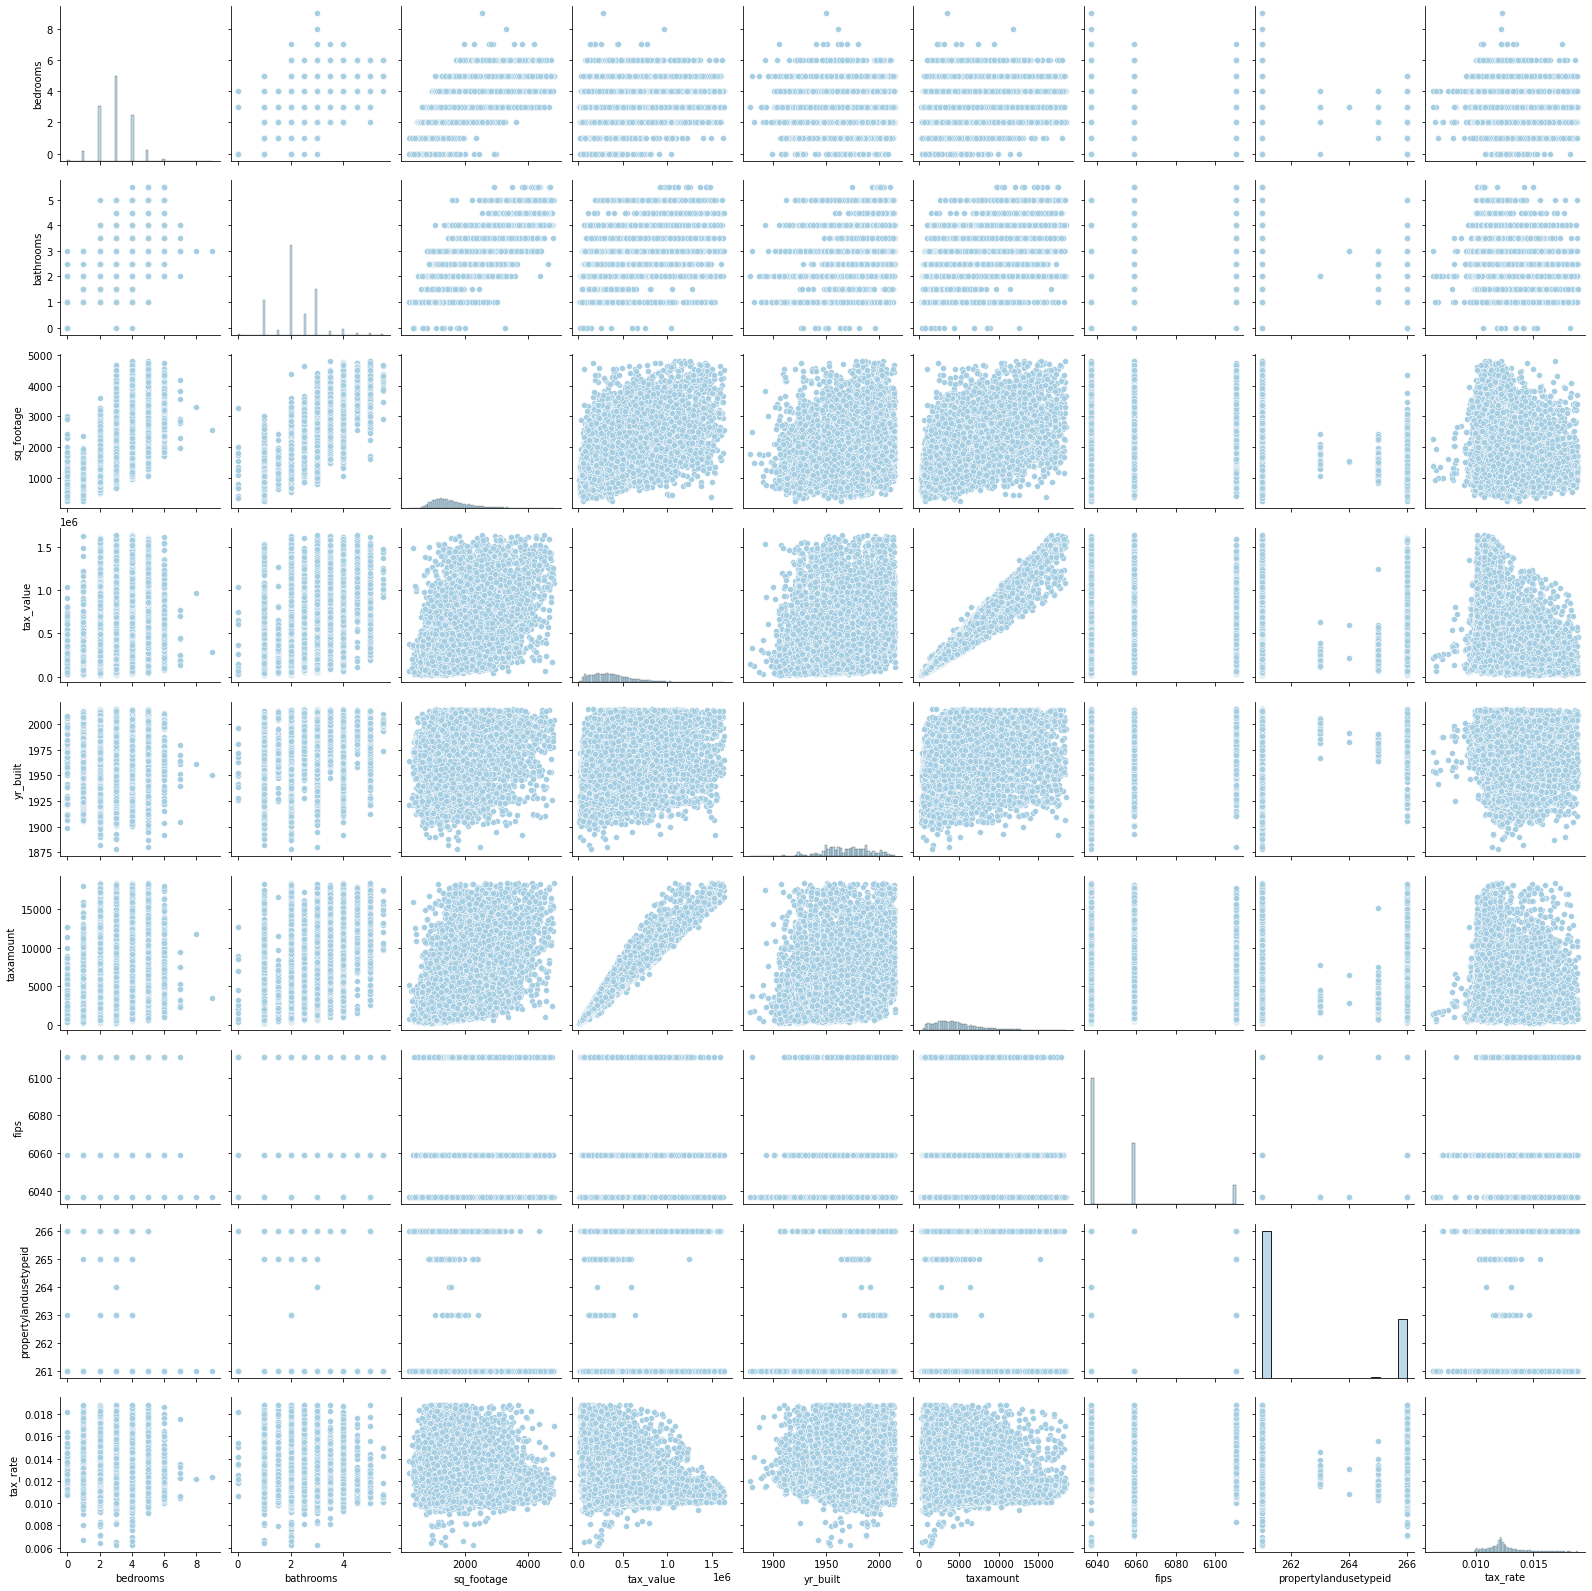

In [25]:
sns.pairplot(train)

In [26]:
#Compare two independent variables with train
train.groupby('bedrooms').bathrooms.mean()

bedrooms
0.0    0.993506
1.0    1.171840
2.0    1.846427
3.0    2.172126
4.0    2.663546
5.0    3.313340
6.0    3.658730
7.0    3.187500
8.0    3.000000
9.0    3.000000
Name: bathrooms, dtype: float64

In [27]:
#Set up x and y 
X_train = train.drop(columns=['tax_value','propertylandusedesc', 'tax_rate', 'county','taxamount','state']) 
X_validate = validate.drop(columns=['tax_value','propertylandusedesc','tax_rate','county','taxamount','state'])
X_test = test.drop(columns=['tax_value','propertylandusedesc','tax_rate','county','taxamount','state'])

y_train = train.tax_value
y_validate = validate.tax_value
y_test = test.tax_value

In [28]:
X_train.shape, X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape

((19643, 6), (8419, 6), (7016, 6), (19643,), (8419,), (7016,))

In [29]:
X_train

bedrooms  bathrooms  sq_footage  yr_built    fips  \
3874        3.0        2.0      1286.0    1960.0  6059.0   
2992        4.0        1.0      1427.0    1929.0  6037.0   
9985        2.0        1.5      1190.0    1979.0  6059.0   
5714        3.0        2.0      1610.0    2005.0  6037.0   
17088       3.0        1.0      1005.0    1947.0  6037.0   
...         ...        ...         ...       ...     ...   
13748       3.0        2.0      1257.0    1956.0  6037.0   
28783       2.0        1.0       864.0    1925.0  6037.0   
31394       2.0        2.0      1949.0    1973.0  6037.0   
24578       3.0        3.0      2784.0    1989.0  6037.0   
18123       3.0        2.5      1673.0    1983.0  6059.0   

       propertylandusetypeid  
3874                   261.0  
2992                   261.0  
9985                   266.0  
5714                   266.0  
17088                  261.0  
...                      ...  
13748                  261.0  
28783                  261.0  
31394                  266.0  
24578                  261.0  
18123                  261.0  

[19643 rows x 6 columns]

In [30]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19643 entries, 3874 to 18123
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bedrooms               19643 non-null  float64
 1   bathrooms              19643 non-null  float64
 2   sq_footage             19643 non-null  float64
 3   yr_built               19643 non-null  float64
 4   fips                   19643 non-null  float64
 5   propertylandusetypeid  19643 non-null  float64
dtypes: float64(6)
memory usage: 1.0 MB


In [31]:
X_train_cols = X_train
X_train_cols.head()

bedrooms  bathrooms  sq_footage  yr_built    fips  \
3874        3.0        2.0      1286.0    1960.0  6059.0   
2992        4.0        1.0      1427.0    1929.0  6037.0   
9985        2.0        1.5      1190.0    1979.0  6059.0   
5714        3.0        2.0      1610.0    2005.0  6037.0   
17088       3.0        1.0      1005.0    1947.0  6037.0   

       propertylandusetypeid  
3874                   261.0  
2992                   261.0  
9985                   266.0  
5714                   266.0  
17088                  261.0

In [32]:
#Scale the data
scaler = StandardScaler()

#Fit and transform the scaler on train
X_train = scaler.fit_transform(X_train)

# Use the scaler to transform validate and test
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

In [33]:
# Turn everything into a dataframe
X_train = pd.DataFrame(X_train, columns=X_train_cols.columns)
X_validate = pd.DataFrame(X_validate, columns=X_train_cols.columns)
X_test = pd.DataFrame(X_test, columns=X_train_cols.columns)

In [34]:
X_train

bedrooms  bathrooms  sq_footage  yr_built      fips  \
0      0.028981  -0.262526   -0.536628 -0.415369  0.394928   
1      1.045546  -1.514482   -0.339378 -1.796128 -0.616969   
2     -0.987584  -0.888504   -0.670925  0.430903  0.394928   
3      0.028981  -0.262526   -0.083374  1.588959 -0.616969   
4      0.028981  -1.514482   -0.929727 -0.994397 -0.616969   
...         ...        ...         ...       ...       ...   
19638  0.028981  -0.262526   -0.577197 -0.593531 -0.616969   
19639 -0.987584  -1.514482   -1.126977 -1.974290 -0.616969   
19640 -0.987584  -0.262526    0.390864  0.163660 -0.616969   
19641  0.028981   0.989429    1.558972  0.876309 -0.616969   
19642  0.028981   0.363451    0.004759  0.609066  0.394928   

       propertylandusetypeid  
0                  -0.637358  
1                  -0.637358  
2                   1.576936  
3                   1.576936  
4                  -0.637358  
...                      ...  
19638              -0.637358  
19639              -0.637358  
19640               1.576936  
19641              -0.637358  
19642              -0.637358  

[19643 rows x 6 columns]

# Explore

In [35]:
# Function to plot categorical and continuous variables

def plot_categorical_and_continuous_vars(categorical_vars, continuous_vars, df, descriptive=None):
    """
    This function that takes in a string name of a categorical variable, 
    a string name from a continuous variable and the df they live in and
    displays 4 different plots.
    """
    for categorical_var in categorical_vars:
        for continuous_var in continuous_vars:
            categorical_label = categorical_var
            continuous_label = continuous_var

            if descriptive:
                categorical_label = descriptive[categorical_var]
                continuous_label = descriptive[continuous_var]
                
            fig, axes = plt.subplots(figsize=(12,36), nrows=4,ncols=1)
            fig.suptitle(f'{continuous_label} by {categorical_label}', fontsize=18, y=1.02)

            sns.lineplot(ax=axes[0], x=categorical_var, y=continuous_var, data=df)
            axes[0].set_title('Line Plot', fontsize=14)
            axes[0].set_xlabel(categorical_label, fontsize=12)
            axes[0].set_ylabel(continuous_label, fontsize=12)
            
            sns.boxplot(ax=axes[1], x=categorical_var, y=continuous_var, data=df,\
                        color='blue')
            axes[1].set_title('Box-and-Whiskers Plot', fontsize=14)
            axes[1].set_xlabel(categorical_label, fontsize=12)
            axes[1].set_ylabel(continuous_label, fontsize=12)
            
            sns.swarmplot(ax=axes[2], x=categorical_var, y=continuous_var, data=df,\
                        palette='Blues')
            axes[2].set_title('Swarm Plot', fontsize=14)
            axes[2].set_xlabel(categorical_label, fontsize=12)
            axes[2].set_ylabel(continuous_label, fontsize=12)
            
            sns.barplot(ax=axes[3], x=categorical_var, y=continuous_var, data=df,\
                        palette='Purples')
            axes[3].set_title('Bar Plot', fontsize=14)
            axes[3].set_xlabel(categorical_label, fontsize=12)
            axes[3].set_ylabel(continuous_label, fontsize=12)
            
            plt.tight_layout()

            plt.show()

In [36]:
categorical_vars = ['bedrooms', 'bathrooms','fips', 'propertylandusetypeid']
continuous_vars = ['sq_footage', 'tax_value']

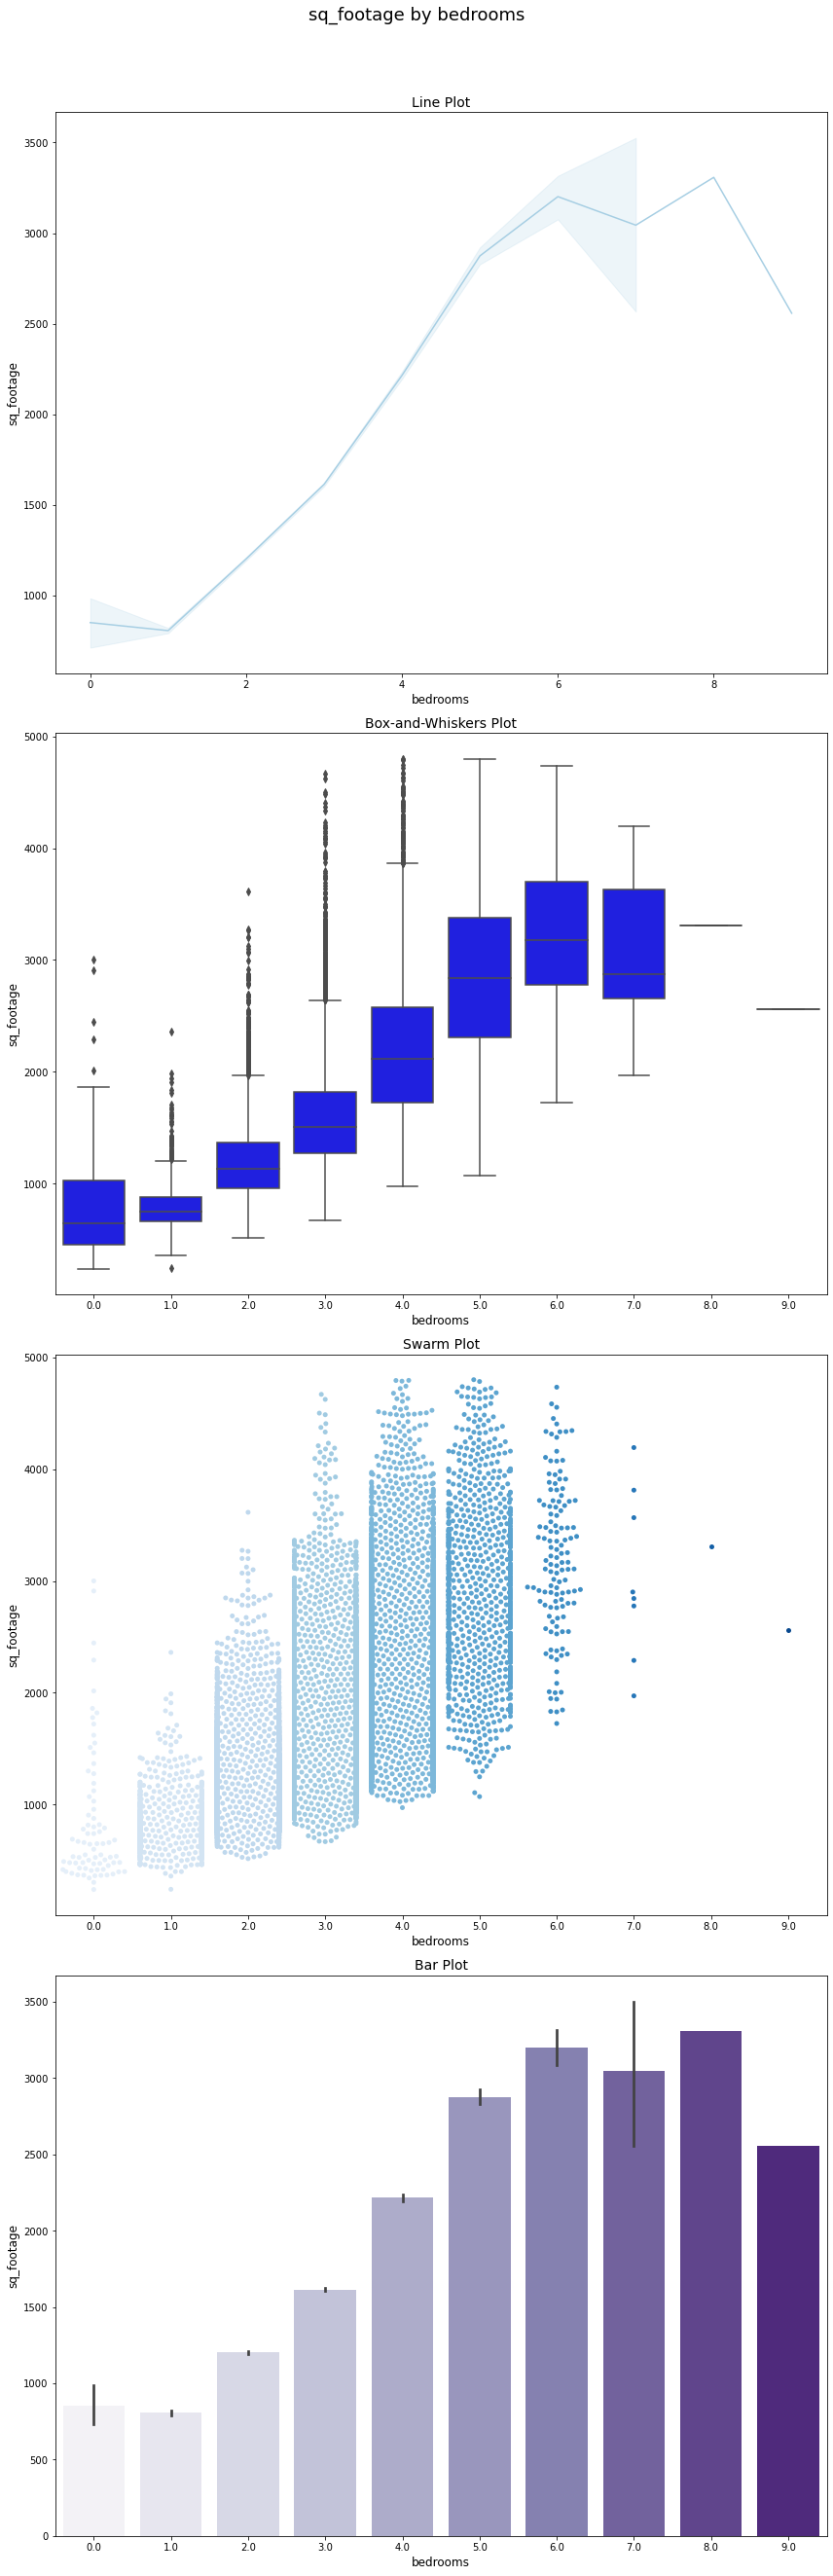

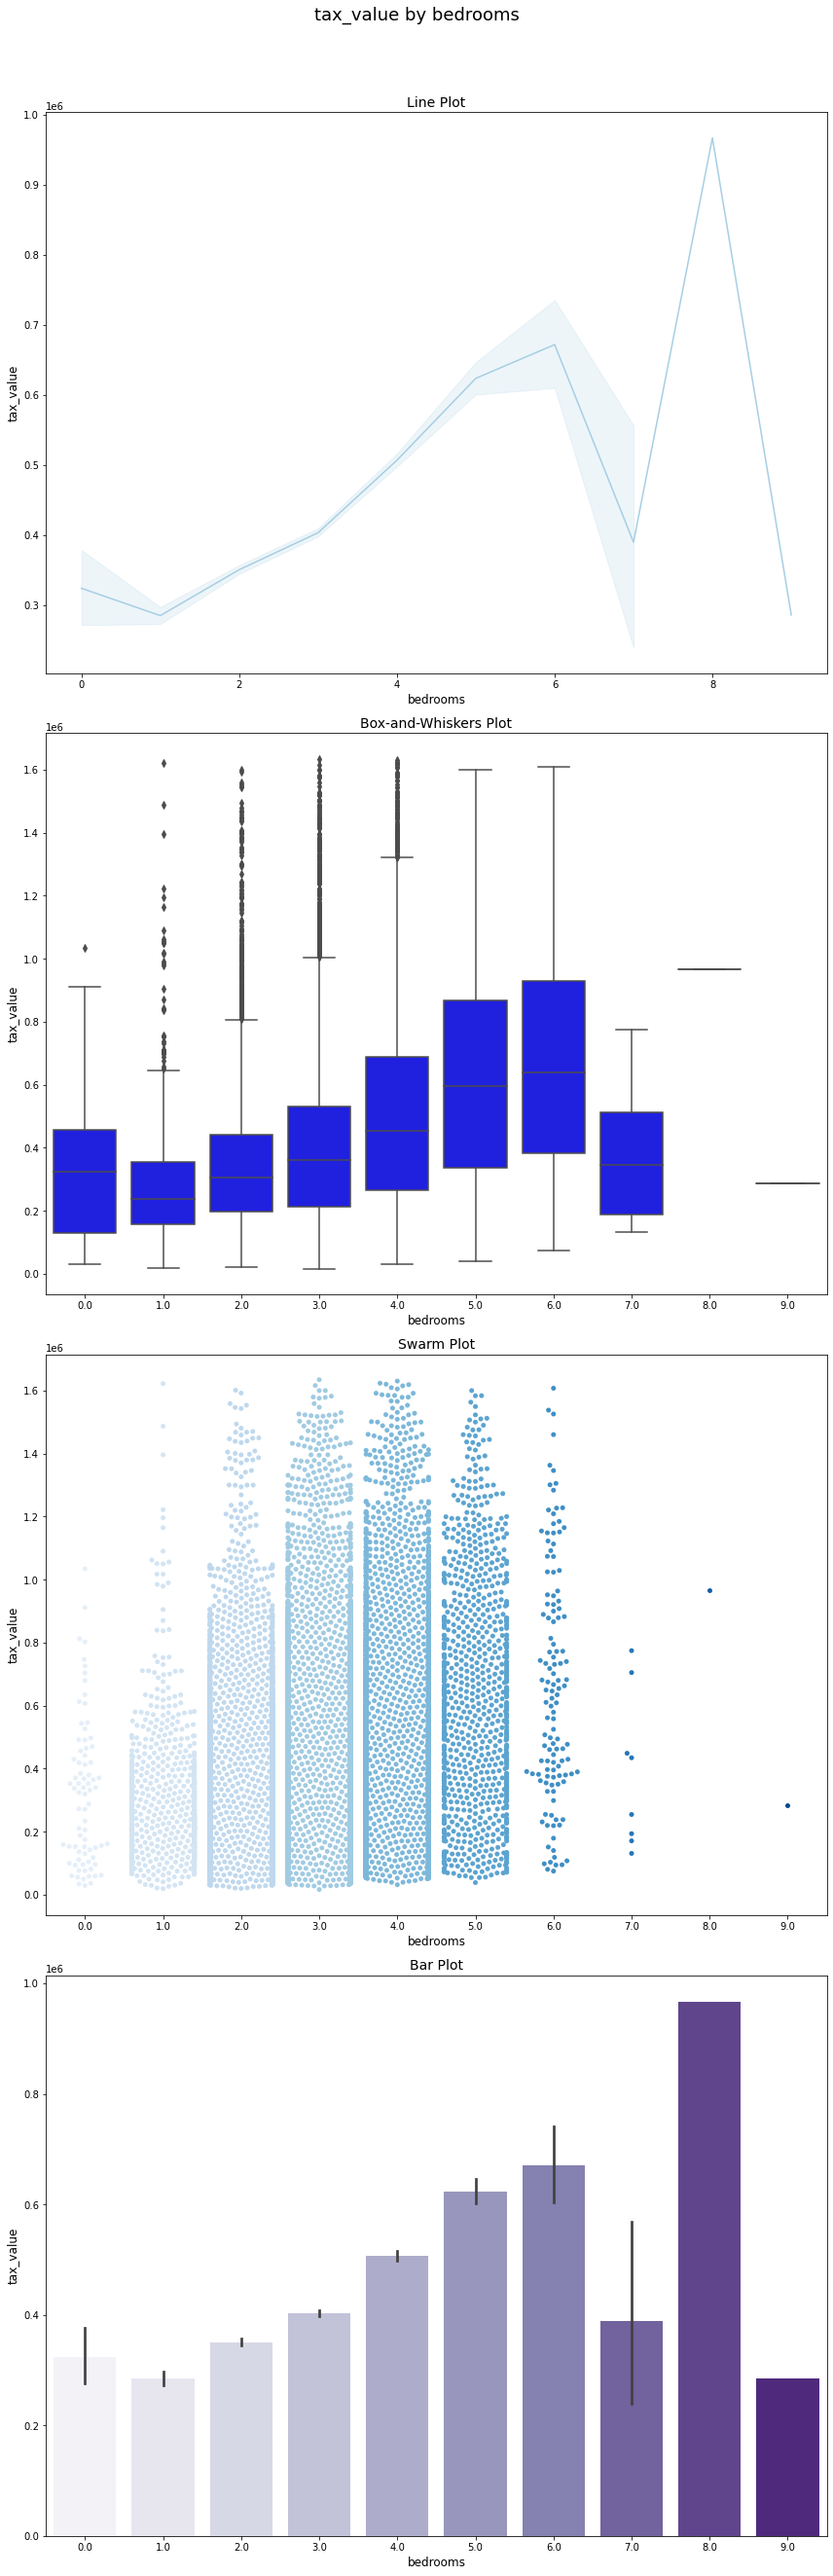

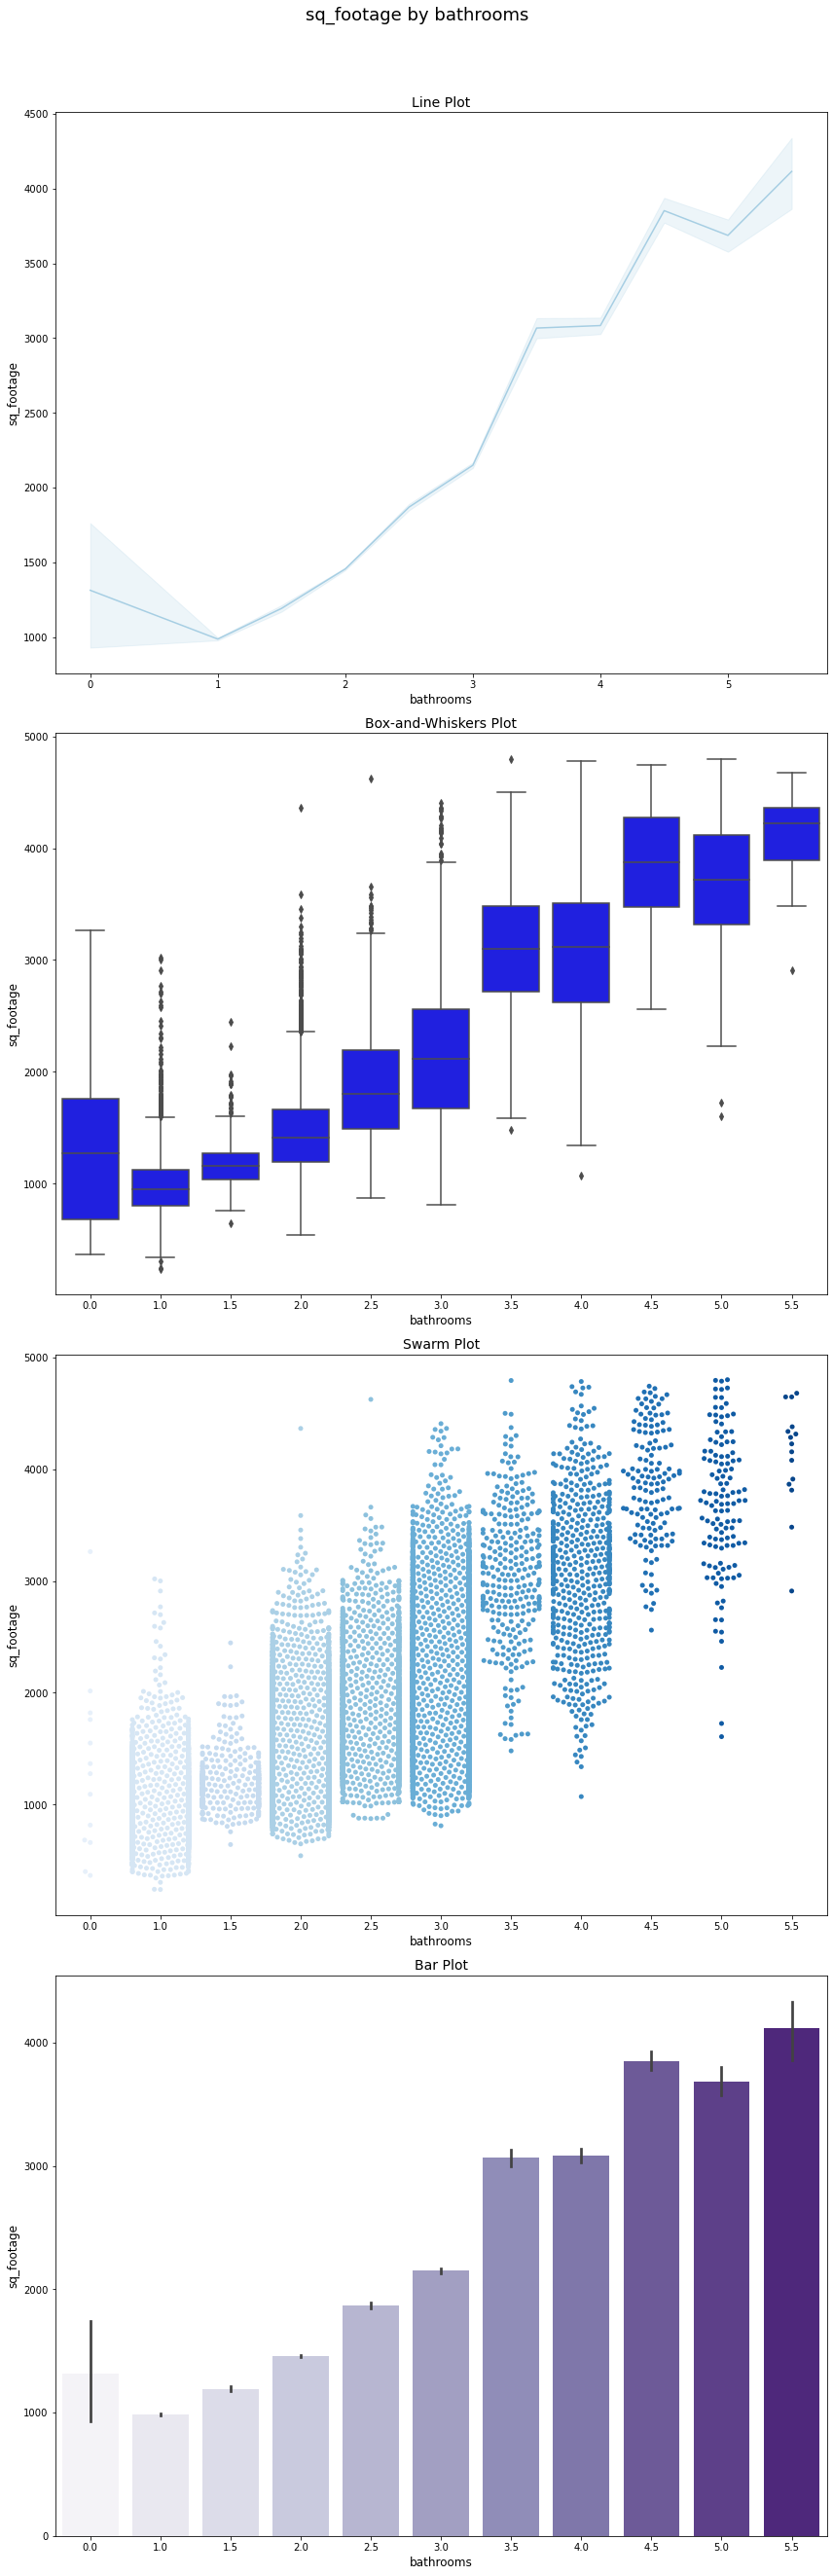

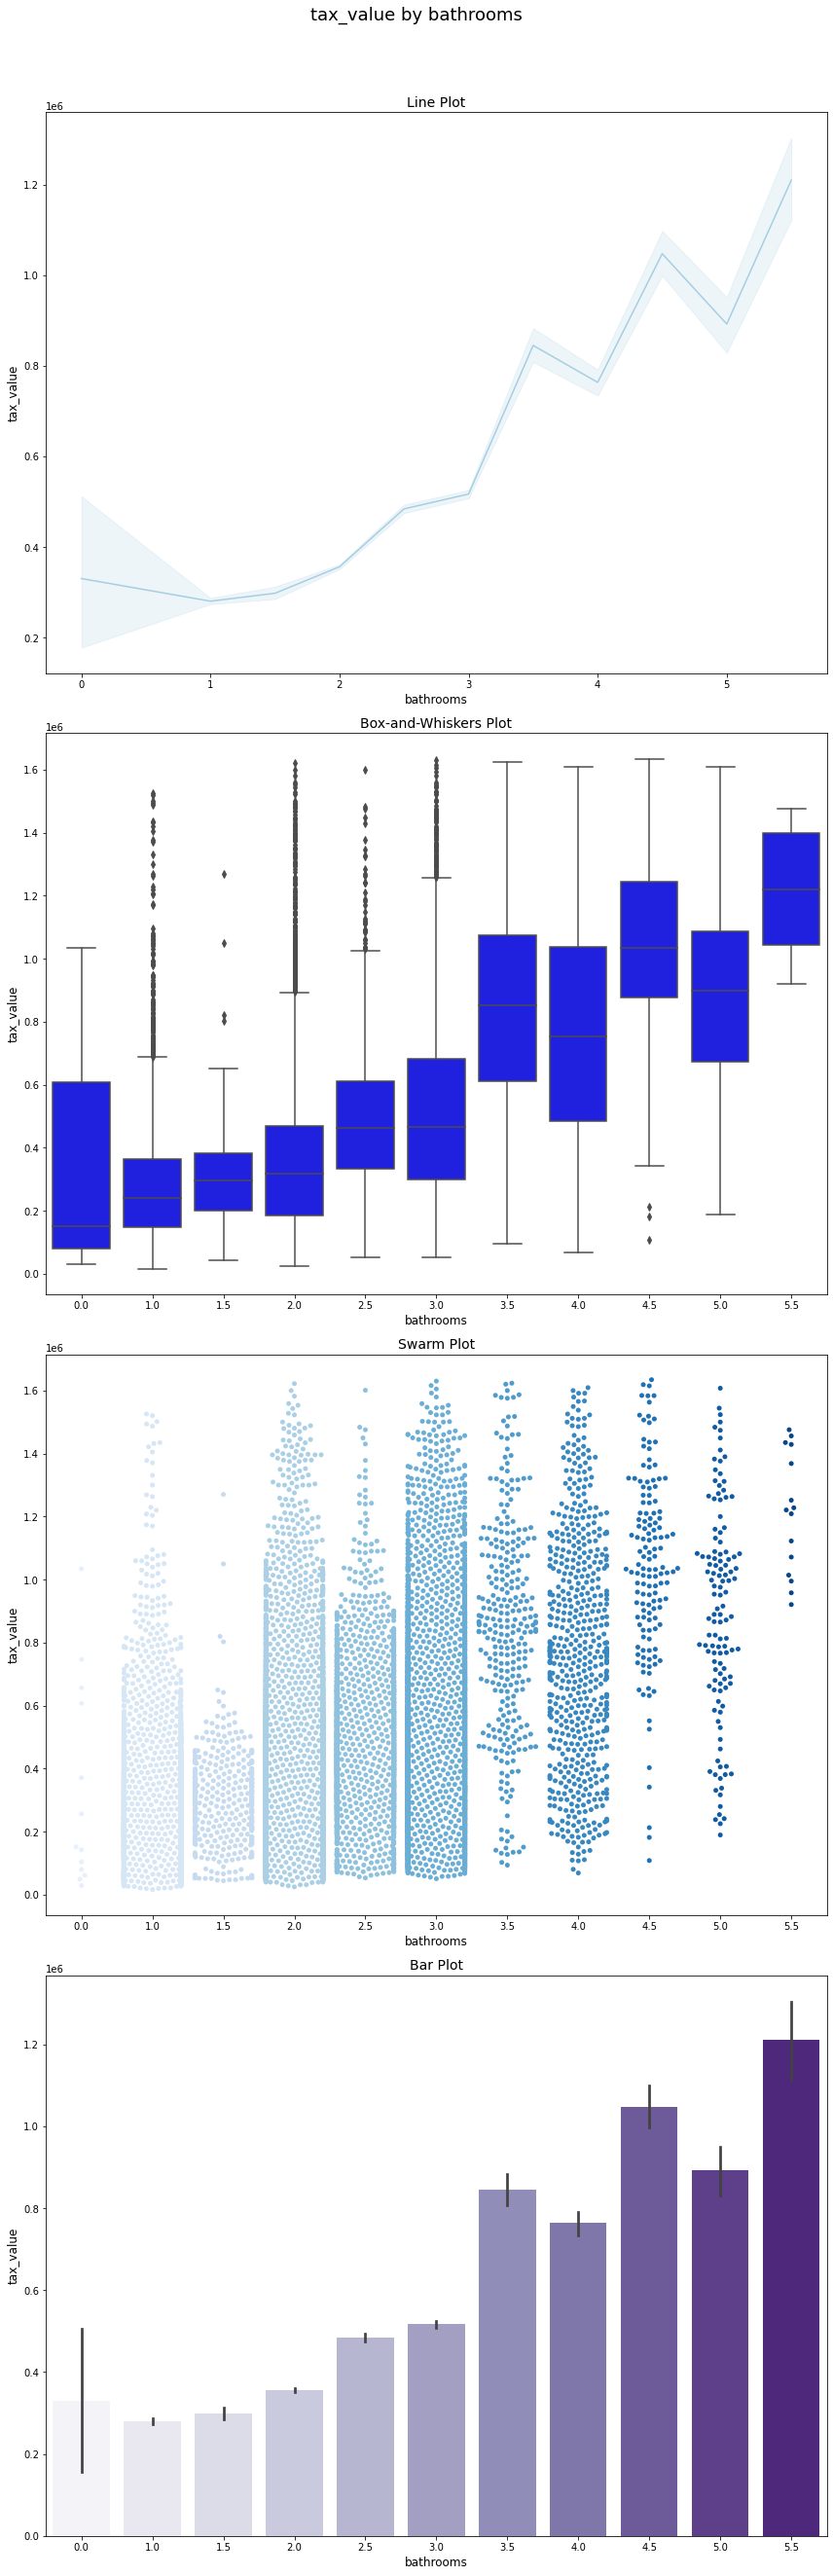

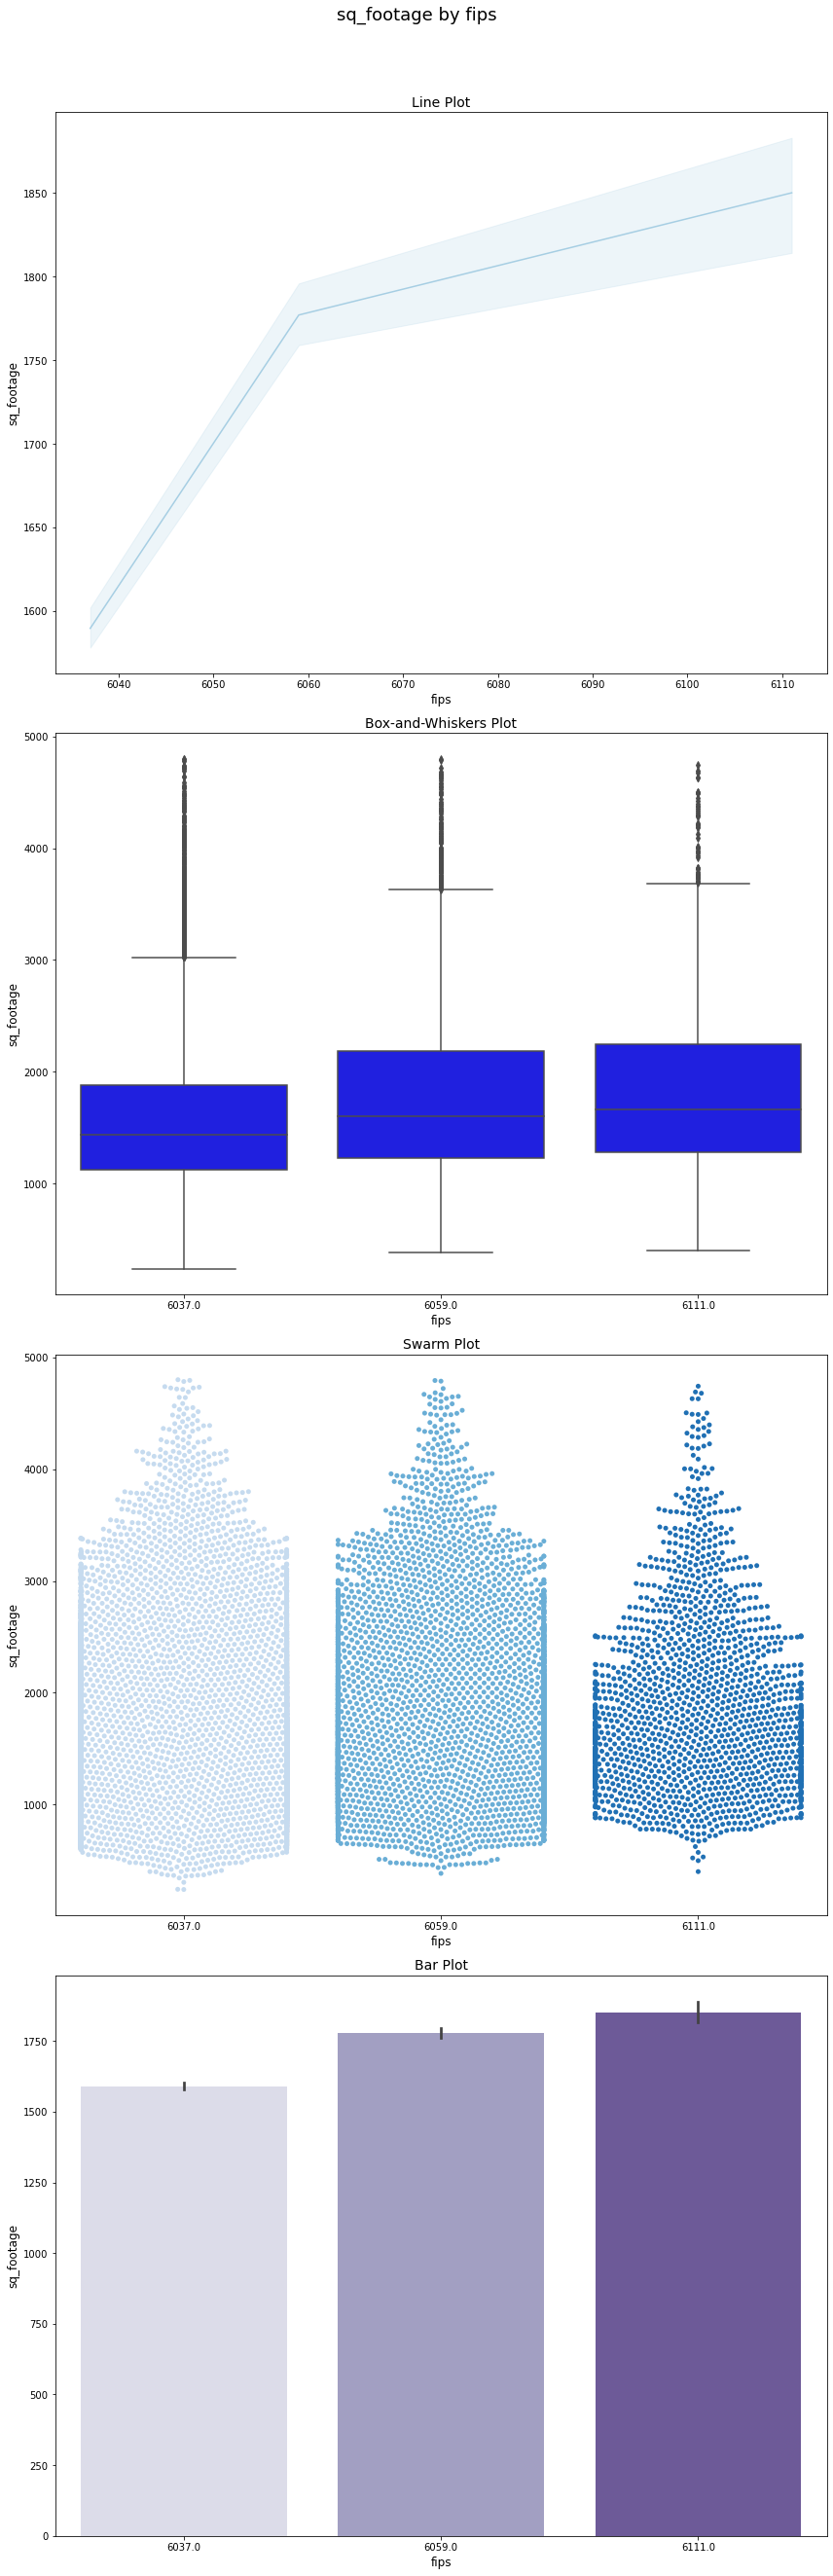

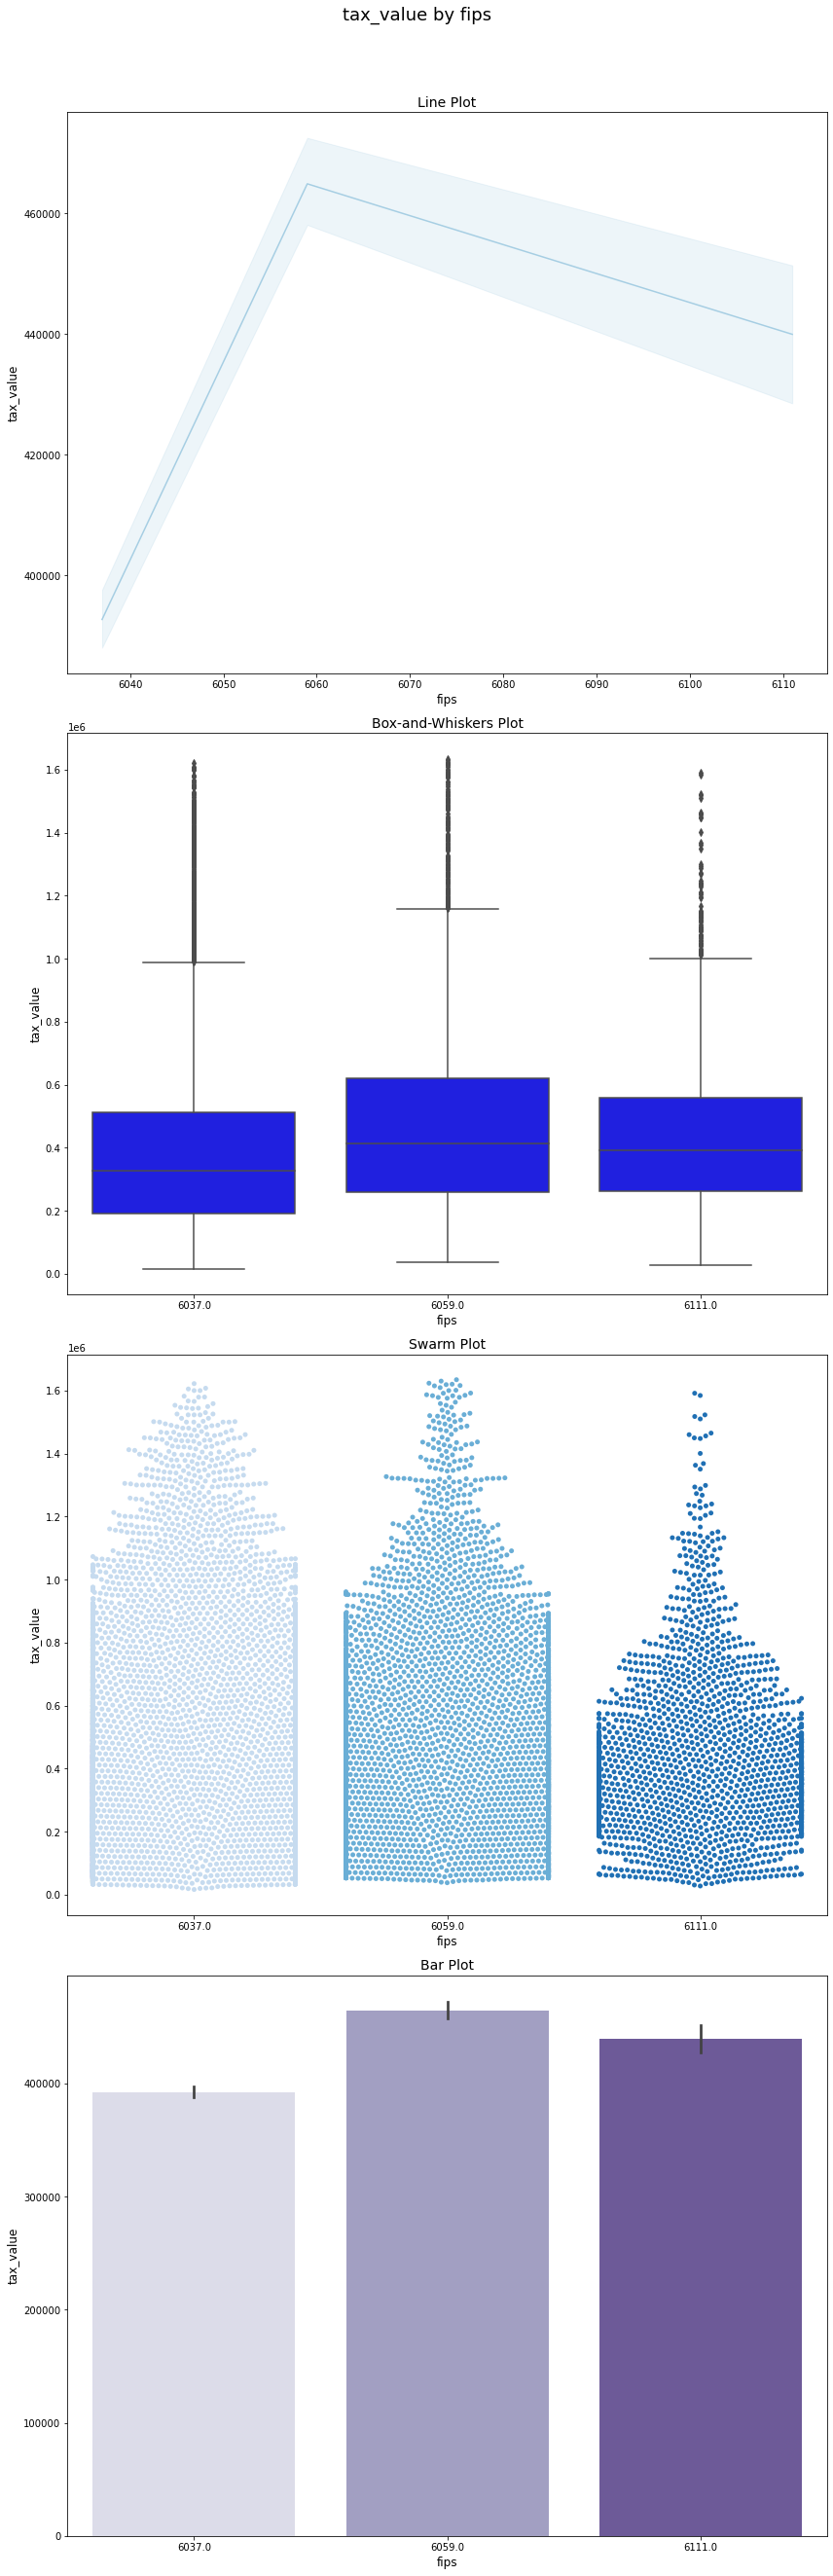

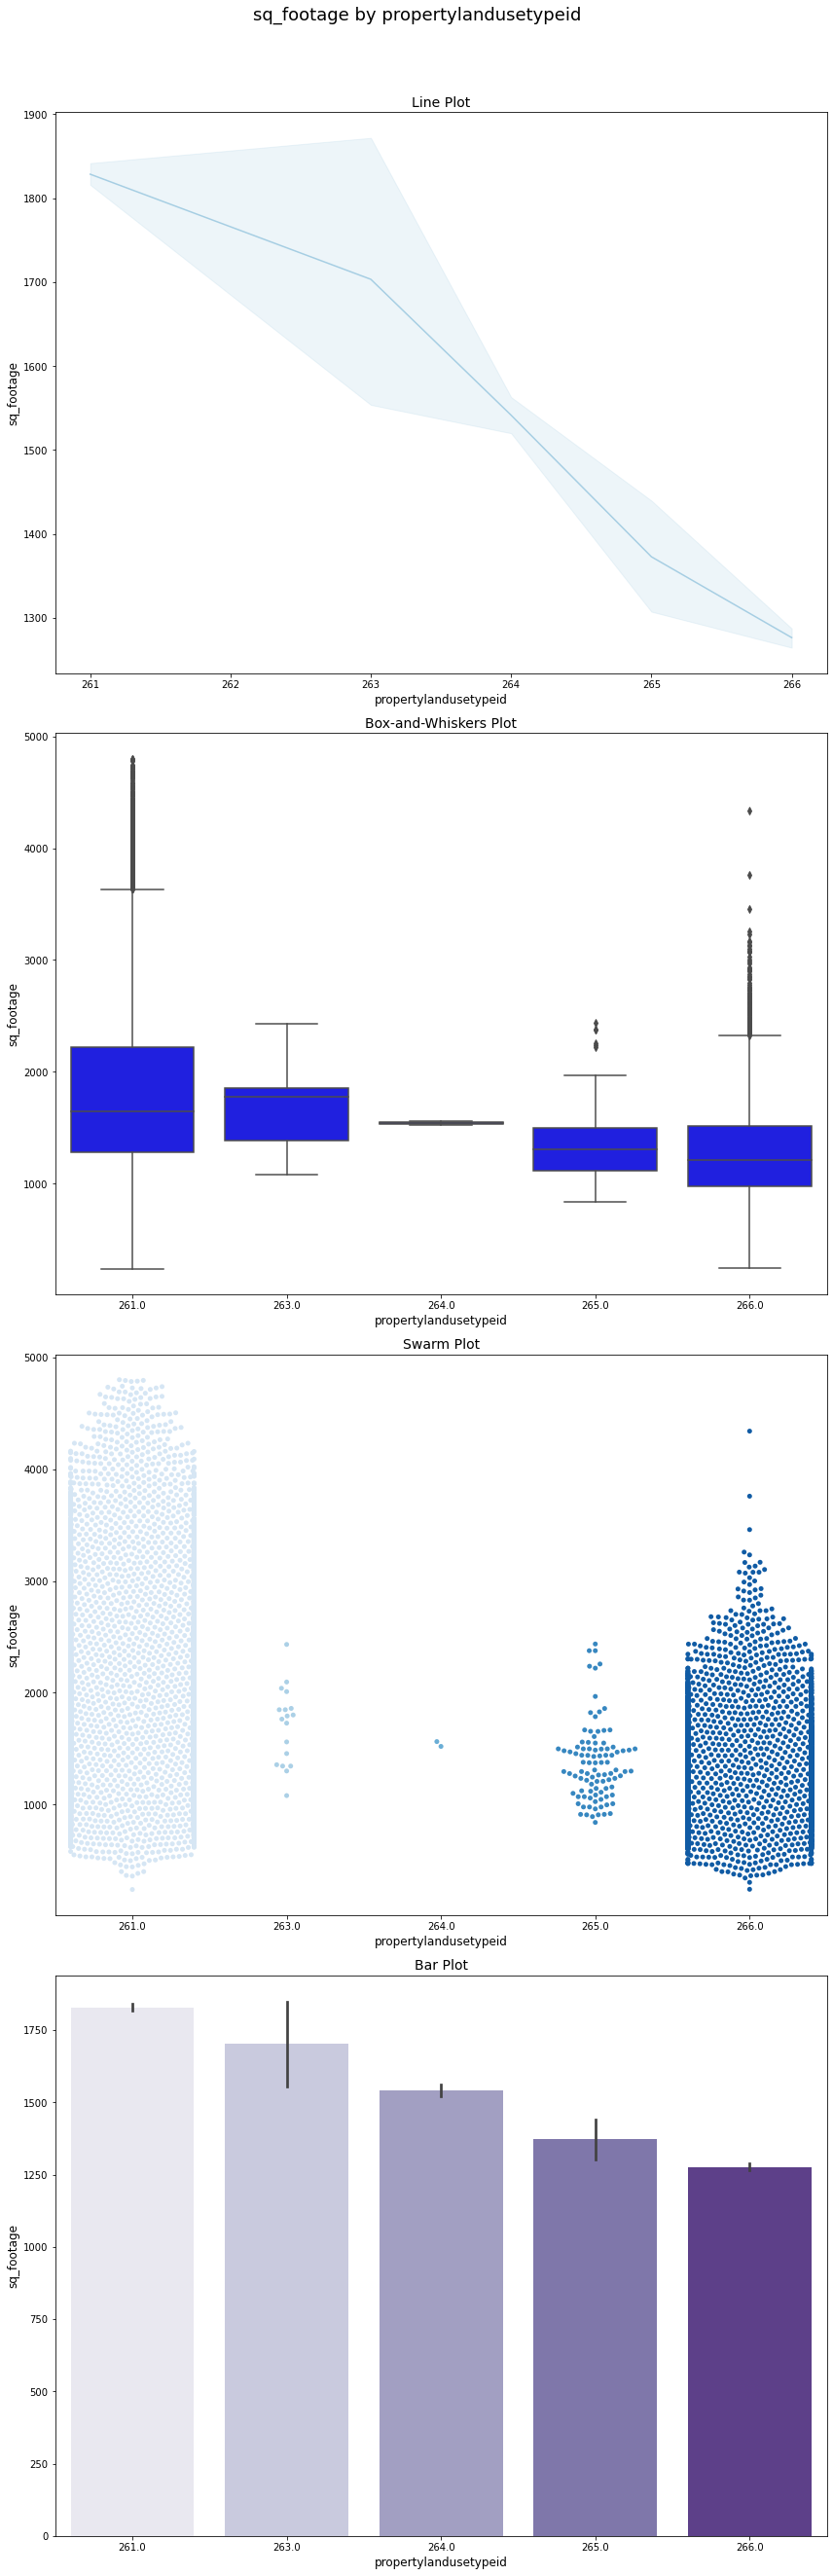

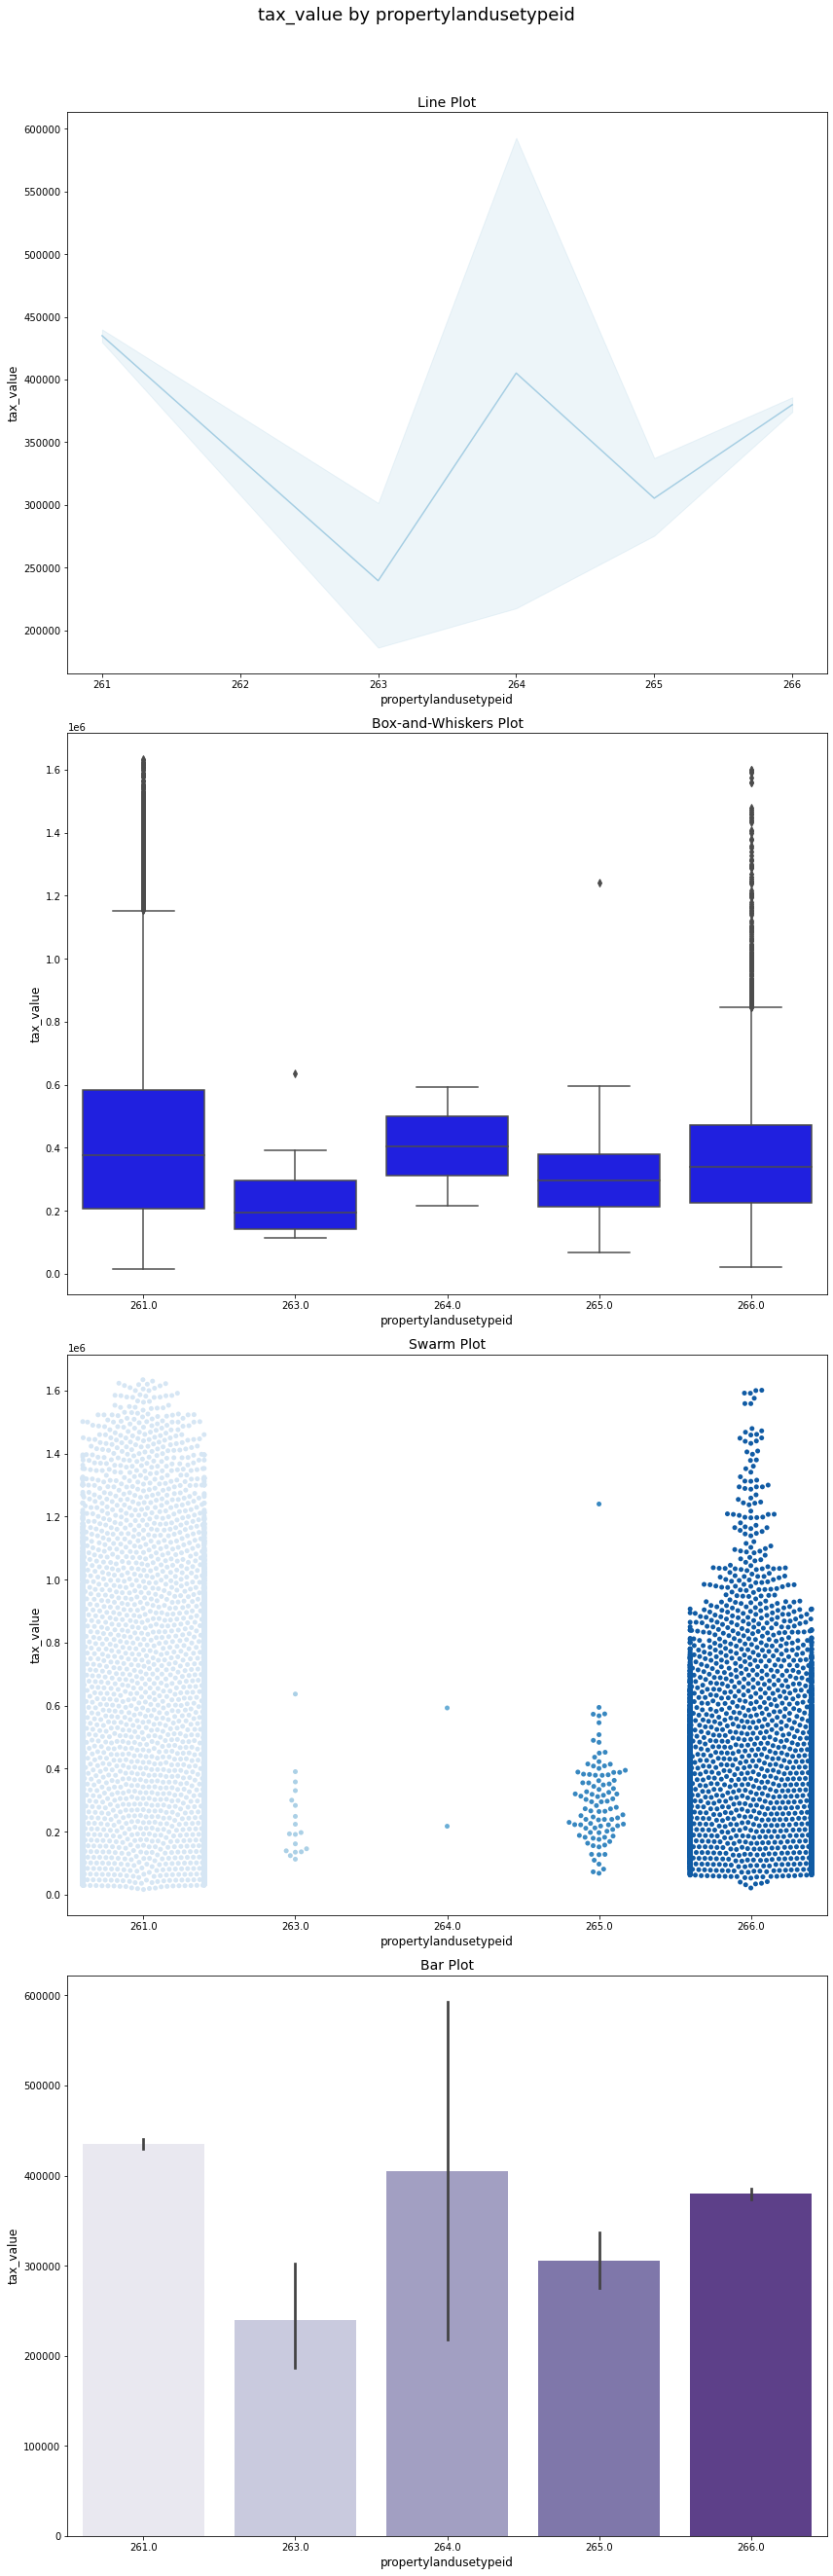

In [37]:
plot_categorical_and_continuous_vars(categorical_vars, continuous_vars, train, descriptive=None)

# Hypotheses

### Visualize and Test

To test my hypothesis, I'm going to create some visualizations and test statistics with the Zillow data.
At the same time, I'll be checking that the key assumptions for multiple linear regression are met.

### Hypothesis 1:
##### Compute test statistic and probability (t-statistic & p-value)

$H_{0}$: Mean of price for single family residential  <= Mean of all single unit properties

$H_{a}$: Mean of price for single family residential > Mean of monthly charges of all customers

In [39]:
single_fam_property_mean = train[train.propertylandusetypeid==261].tax_value.mean()
single_fam_property_mean

435005.6542484597

In [40]:
#Set alpha
alpha = .05

In [41]:
all_single_units_price_mean = train.tax_value.mean()
all_single_units_price_mean

418560.92399328004

In [42]:
single_fam_property = train[train.propertylandusetypeid==261].tax_value

all_single_units_price = train.tax_value

In [43]:
t, p = stats.ttest_1samp(single_fam_property, all_single_units_price_mean)

print(t, p, p/2, alpha)

6.396548085218375 1.6399457186780426e-10 8.199728593390213e-11 0.05


In [44]:
if p/2 > alpha:
    print("We fail to reject $H_{0}$, that Mean of price for single family residential <= Mean of all single unit properties")
elif t < 0:
    print("We fail to reject $H_{0}$, that Mean of price for single family residential <= Mean of all single unit properties")
else:
    print("We reject $H_{0}$, Mean of price for single family residential <= Mean of all single unit properties")

We reject $H_{0}$, Mean of price for single family residential <= Mean of all single unit properties


Text(0.5, 1.0, 'Single Family Homes Distribution')

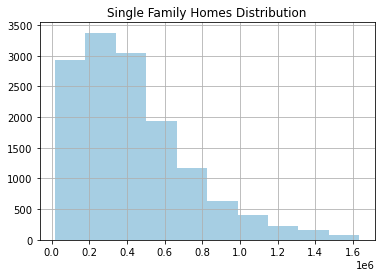

In [45]:
single_fam_property.hist()
plt.title("Single Family Homes Distribution")

Text(0.5, 1.0, 'All Single Unit Properties Distribution')

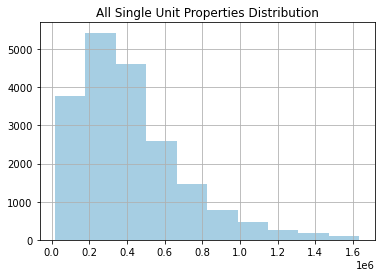

In [46]:
all_single_units_price.hist()
plt.title("All Single Unit Properties Distribution")

 ### Hypothesis 2:
 $ Ho $
: Null Hypothesis: There is no correlation between the square footage and price.

$ H \alpha$ : Alternative Hypothesis: Square footage and price are correlated.

In [47]:
x = train.sq_footage
y = train.tax_value

In [48]:
corr, p = stats.pearsonr(x, y)
corr, p

(0.5378319986063269, 0.0)

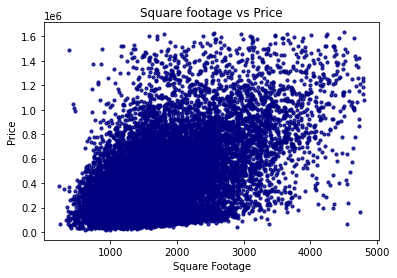

In [49]:
plt.scatter(x, y, s=10, c='navy', alpha=.8)
plt.title('Square footage vs Price')
plt.xlabel("Square Footage")
plt.ylabel("Price")
plt.yscale(value='linear')

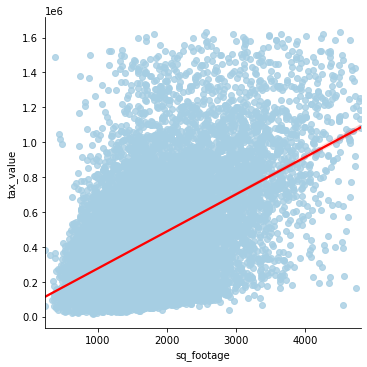

In [50]:
sns.lmplot(x="sq_footage", y="tax_value", data=train, line_kws={'color': 'red'})
plt.show()

Text(0.5, 1.0, 'Price vs Square Feet')

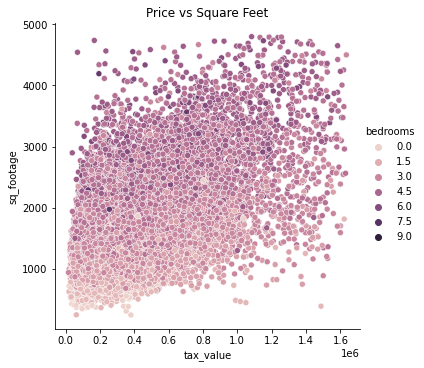

In [125]:
sns.relplot(x="tax_value", y="sq_footage", hue="bedrooms", data=train);
plt.title("Price vs Square Feet")

 ### Hypothesis 3:
 
 $ Ho $
: Null Hypothesis: There is no correlation between number of bedrooms and location (fips).

$ H \alpha$ : Alternative Hypothesis: Number of bedrooms and location (fips) are correlated.

In [51]:
observed = pd.crosstab(train.bedrooms, train.fips)
observed

fips      6037.0  6059.0  6111.0
bedrooms                        
0.0           73       1       3
1.0          614     262      26
2.0         3468    1397     341
3.0         4981    2329     719
4.0         2275    1470     581
5.0          498     328     141
6.0           63      50      13
7.0            6       1       1
8.0            1       0       0
9.0            1       0       0

In [52]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p

(387.3685742290478, 3.92136310072856e-71)

In [53]:
# P is way low so we reject the null hypothesis that there is no correlation between number of bedrooms and location

 ### Hypothesis 4:
 
 $ Ho $
: Null Hypothesis: There is no correlation between number of bathrooms and price .

$ H \alpha$ : Alternative Hypothesis: Number of bedrooms and price.

In [54]:
x = train.bathrooms
y = train.tax_value

In [55]:
corr, p = stats.pearsonr(x, y)
corr, p

(0.44929450422759704, 0.0)

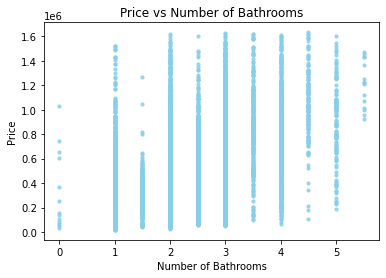

In [56]:
plt.scatter(x, y, s=10, c='skyblue', alpha=.8)
plt.title('Price vs Number of Bathrooms')
plt.xlabel("Number of Bathrooms")
plt.ylabel("Price")
plt.yscale(value='linear')

# Takeaways of Exploration

- All 4 null hypothesis with square footage, number of bedrooms, number of bathrooms and property type not being correlated to price were rejected
- In looking at the visualizations, there is a clear relationship between price features
    - As number of bedrooms, square footage, and bathrooms goes up, so does price
    - Property type does affect price, whether townhome vs mobile home vs single family residential

## Modeling

**Look at the Target Variable/y**

This helps us determine which type of algorithm we may want to use. 

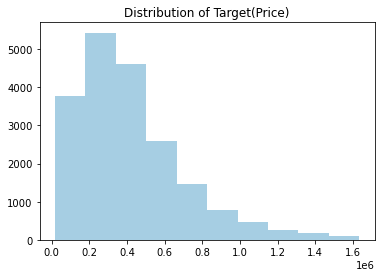

In [57]:
# how do we determine distribution?
plt.hist(y_train)
plt.title('Distribution of Target(Price)')
plt.show()

In [58]:
len(y_train)

19643

In [59]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)
y_train.head()

tax_value
3874    265613.0
2992    201228.0
9985    143822.0
5714    395023.0
17088    49691.0

In [60]:
y_validate.head()

tax_value
4501    324444.0
37785   395000.0
15883    79860.0
11610   458367.0
2409    568539.0

### Feature Engineering

#### Recursive Feature Elimination
- Fits a model and eliminates the worst performing features
- Looks at all the features together

In [61]:
from sklearn.feature_selection import SelectKBest, f_regression

In [62]:
rfe = RFE(estimator=LinearRegression(), n_features_to_select=1)
rfe.fit(X_train, y_train)
rfe.get_support()

array([False, False,  True, False, False, False])

In [63]:
X_train.columns[rfe.get_support()]

Index(['sq_footage'], dtype='object')

In [64]:
rfe.ranking_

array([2, 3, 1, 6, 5, 4])

In [65]:
pd.Series(rfe.ranking_, index=X_train.columns)

bedrooms                 2
bathrooms                3
sq_footage               1
yr_built                 6
fips                     5
propertylandusetypeid    4
dtype: int64

In [66]:
# Bedrooms, Bathrooms, and Square Footage were the top 3 features identified with the Select K Best feature selection.
# Make sure to include those in my model.

### Baseline

About the initial baseline: 

> Before we begin making models, we need to know how well we can estimate (predict) the final price (tax_value) without using any features. This is often done by predicting every observation's target value to be the mean or the median. E.g. we could predict every price to be the mean price of all the properties in our training sample. We will try both the mean and the median, see which performs best, and set that evaluation metric value as our baseline performance to beat. 


1. Predict all prices to be $418,560.92, which is equal to the mean of tax_value for the training sample. Store in `y_train['price_pred_mean']`. 


2. Predict all final prices to be $359,073.00, which is equal to the median of tax_value for the training sample. Store in `y_train['price_pred_median']`.  


3. Compute the RMSE comparing actual final price (tax_value) to price_pred_mean. 


4. Compute the RMSE comparing actual final price (tax_value) to price_pred_median. 

In [67]:
# 1. Predict price_pred_mean
price_pred_mean = y_train.tax_value.mean()
y_train['price_pred_mean'] = price_pred_mean
y_validate['price_pred_mean'] = price_pred_mean

In [68]:
round(price_pred_mean,2)

418560.92

In [69]:
# 2. compute price_pred_median
price_pred_median = y_train.tax_value.median()
y_train['price_pred_median'] = price_pred_median
y_validate['price_pred_median'] = price_pred_median

round(price_pred_median,2)

359073.0

In [70]:
# 3. RMSE of price_pred_mean
rmse_train = mean_squared_error(y_train.tax_value,
                                y_train.price_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_mean) ** (1/2)

In [71]:
rmse_train_2 = mean_squared_error(y_train.tax_value,
                                y_train.price_pred_mean, squared = False)
rmse_validate_2 = mean_squared_error(y_validate.tax_value, y_validate.price_pred_mean, squared = False)

In [72]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  282835.82 
Validate/Out-of-Sample:  286325.42


In [73]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train_2, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_2, 2))

RMSE using Mean
Train/In-Sample:  282835.82 
Validate/Out-of-Sample:  286325.42


In [74]:
# 4. RMSE of price_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  289024.08 
Validate/Out-of-Sample:  293813.94



#### Addendum/Note:
we will incrementally build 
a dataframe for comparison of 
our metrics for model selection
for ease of reflection

In [75]:
def make_metric_df(y, y_pred, model_name, metric_df):
    if metric_df.size ==0:
        metric_df = pd.DataFrame(data=[
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }])
        return metric_df
    else:
        return metric_df.append(
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }, ignore_index=True)

In [76]:
# create the metric_df as a blank dataframe
metric_df = pd.DataFrame()
# make our first entry into the metric_df with median baseline
metric_df = make_metric_df(y_train.tax_value,
                           y_train.price_pred_median,
                           'median_baseline',
                          metric_df)

In [77]:
metric_df

model  RMSE_validate  r^2_validate
0  median_baseline  289024.076511           0.0

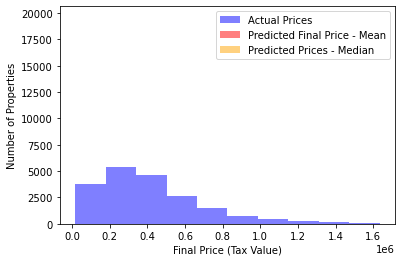

In [78]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.tax_value, color='blue', alpha=.5, label="Actual Prices")
plt.hist(y_train.price_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Final Price - Mean")
plt.hist(y_train.price_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Prices - Median")
plt.xlabel("Final Price (Tax Value)")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()

### LinearRegression (OLS)

1. Fit the model using X_train (scaled) and the labels from y_train. 

2. Predict final price for properties in training sample using our model (lm). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 


In [79]:
y_train.head()

tax_value  price_pred_mean  price_pred_median
3874    265613.0    418560.923993           359073.0
2992    201228.0    418560.923993           359073.0
9985    143822.0    418560.923993           359073.0
5714    395023.0    418560.923993           359073.0
17088    49691.0    418560.923993           359073.0

In [80]:
# create the model object
# 
# make the thing
# 
lm = LinearRegression(normalize=True)

In [81]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
lm.fit(X_train, y_train.tax_value)

LinearRegression(normalize=True)

In [82]:
# predict train
# 
# use the thing!
# 
y_train['price_pred_lm'] = lm.predict(X_train)

In [83]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_lm) ** (1/2)

# predict validate
y_validate['price_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  234273.54216836728 
Validation/Out-of-Sample:  235602.3974886665


In [84]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.price_pred_lm)}, ignore_index=True)

In [85]:
metric_df

model  RMSE_validate  r^2_validate
0  median_baseline  289024.076511      0.000000
1    OLS Regressor  235602.397489      0.322994

### LassoLars

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final price for properties in training sample using our model (lars). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 
 

In [86]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['price_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_lars) ** (1/2)

# predict validate
y_validate['price_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  234273.87488428602 
Validation/Out-of-Sample:  235603.59594477425


In [87]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.price_pred_lars,
               'lasso_alpha_1',
               metric_df)

In [88]:
metric_df

model  RMSE_validate  r^2_validate
0  median_baseline  289024.076511      0.000000
1    OLS Regressor  235602.397489      0.322994
2    lasso_alpha_1  235603.595945      0.322988

### Tried a higher alpha to see if that translates into a lower RMSE, but it didn't.  Sticking with alpha = 1 for lower RMSE.

### TweedieRegressor (GLM)

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final price for properties in training sample using our model (glm). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [89]:
# create the model object
lars = LassoLars(alpha=4)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['price_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_lars) ** (1/2)

# predict validate
y_validate['price_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  234278.86556636548 
Validation/Out-of-Sample:  235611.29522817445


In [90]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['price_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_glm) ** (1/2)

# predict validate
y_validate['price_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  236002.25131800192 
Validation/Out-of-Sample:  237588.37640590436


In [91]:
make_metric_df(y_validate.tax_value,
               y_validate.price_pred_glm,
               'glm_poisson',
               metric_df)

model  RMSE_validate  r^2_validate
0  median_baseline  289024.076511      0.000000
1    OLS Regressor  235602.397489      0.322994
2    lasso_alpha_1  235603.595945      0.322988
3      glm_poisson  237588.376406      0.311527

In [92]:
### Using a different power to try the fit to a different distribution

In [93]:
# create the model object
glm = TweedieRegressor(power=3, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['price_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_glm) ** (1/2)

# predict validate
y_validate['price_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  282835.8246434801 
Validation/Out-of-Sample:  286325.4212400895


### Polynomial Regression

Using sklearn.preprocessing.PolynommialFeatures() + sklearn.linear_model.LinearRegression()

1. Create the new features, based on value indicated for degree for train, validate & test. 

2. Fit the Linear Regression model

3. Predict using the transformed (squared or cubed, e.g.) features 

4. Evaluate using RMSE

5. Repeat predictions and evaluation for validation.

6. Compare RMSE train vs. validation. Overfitting?

## **PolynomialFeatures**

In [94]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

## **LinearRegression**

In [95]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['price_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_lm2) ** (1/2)

# predict validate
y_validate['price_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_lm2) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  228502.59820929402 
Validation/Out-of-Sample:  231084.2057746938


In [96]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.price_pred_lm2,
               'quadratic',
               metric_df)

In [97]:
metric_df

model  RMSE_validate  r^2_validate
0  median_baseline  289024.076511      0.000000
1    OLS Regressor  235602.397489      0.322994
2    lasso_alpha_1  235603.595945      0.322988
3        quadratic  231084.205775      0.348596

In [98]:
# Trying a degree of 3 to check performance

In [99]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 =  pf.transform(X_test)

In [100]:
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['price_pred_lm3'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_lm3) ** (1/2)

# predict validate
y_validate['price_pred_lm3'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_lm3) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  224866.54034150744 
Validation/Out-of-Sample:  228223.05474288153


In [101]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.price_pred_lm3,
               '3degree_quadratic',
               metric_df)
metric_df

model  RMSE_validate  r^2_validate
0    median_baseline  289024.076511      0.000000
1      OLS Regressor  235602.397489      0.322994
2      lasso_alpha_1  235603.595945      0.322988
3          quadratic  231084.205775      0.348596
4  3degree_quadratic  228223.054743      0.364573

In [102]:
# Trying a degree of 4 to check performance

In [103]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=4)

# fit and transform X_train_scaled
X_train_degree4 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree4 = pf.transform(X_validate)
X_test_degree4 =  pf.transform(X_test)

In [104]:
# create the model object
lm4 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm4.fit(X_train_degree4, y_train.tax_value)

# predict train
y_train['price_pred_lm4'] = lm4.predict(X_train_degree4)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_lm4) ** (1/2)

# predict validate
y_validate['price_pred_lm4'] = lm4.predict(X_validate_degree4)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_lm4) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  222469.24045964127 
Validation/Out-of-Sample:  123201898964089.2


In [105]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.price_pred_lm4,
               '4degree_quadratic',
               metric_df)
metric_df

model  RMSE_validate  r^2_validate
0    median_baseline   2.890241e+05  0.000000e+00
1      OLS Regressor   2.356024e+05  3.229942e-01
2      lasso_alpha_1   2.356036e+05  3.229875e-01
3          quadratic   2.310842e+05  3.485960e-01
4  3degree_quadratic   2.282231e+05  3.645728e-01
5  4degree_quadratic   1.232019e+14 -1.852354e+17

### Evaluate

**Plotting Actual vs. Predicted Values**

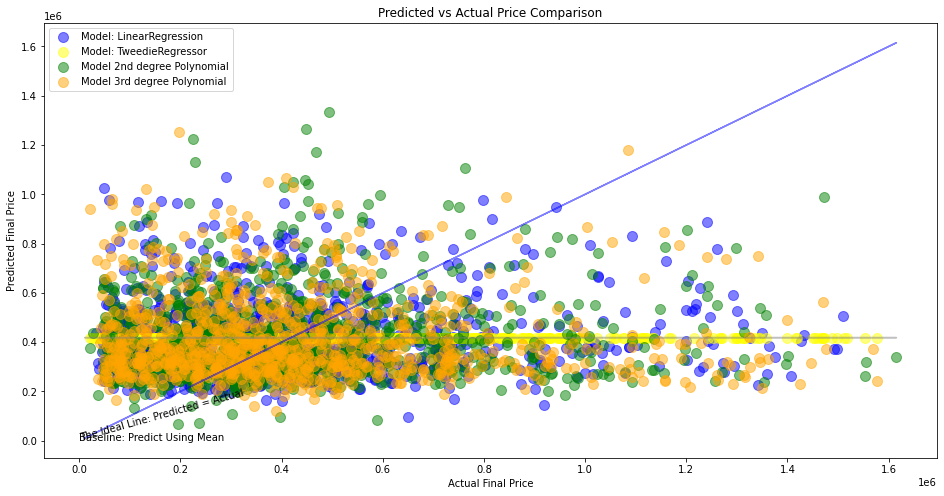

In [106]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.price_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value.sample(n=1000), y_validate.price_pred_lm.sample(n=1000), 
            alpha=.5, color="blue", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value.sample(n=1000), y_validate.price_pred_glm.sample(n=1000), 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value.sample(n=1000), y_validate.price_pred_lm2.sample(n=1000), 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.scatter(y_validate.tax_value.sample(n=1000), y_validate.price_pred_lm3.sample(n=1000), 
            alpha=.5, color="orange", s=100, label="Model 3rd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Price")
plt.ylabel("Predicted Final Price")
plt.title("Predicted vs Actual Price Comparison")
plt.show()

**Residual Plots: Plotting the Errors in Predictions**

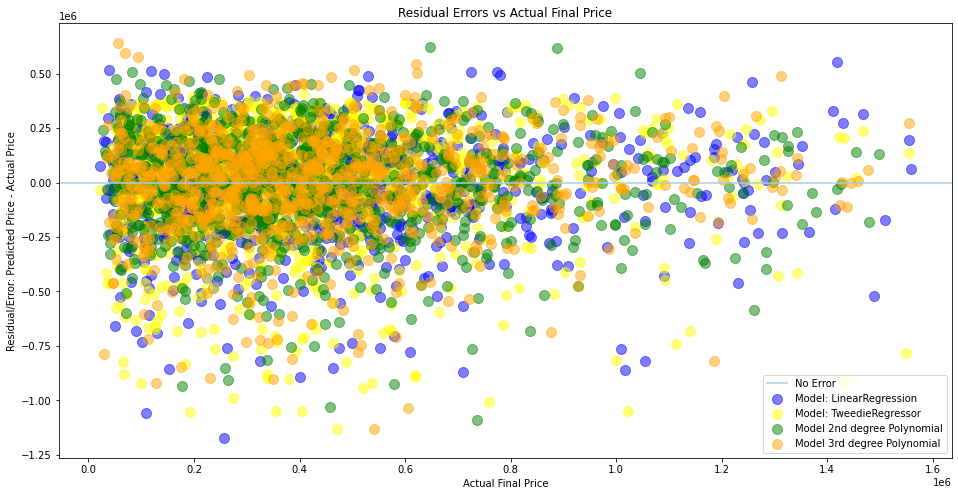

In [107]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
y_lm = y_validate.price_pred_lm - y_validate.tax_value
y_glm = y_validate.price_pred_glm - y_validate.tax_value
y_lm2 = y_validate.price_pred_lm2 - y_validate.tax_value
y_lm3 = y_validate.price_pred_lm3 - y_validate.tax_value



plt.scatter(y_validate.tax_value.sample(n=1000), y_lm.sample(n=1000) , 
            alpha=.5, color="blue", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value.sample(n=1000), y_glm.sample(n=1000) , 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value.sample(n=1000), y_lm2.sample(n=1000) , 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.scatter(y_validate.tax_value.sample(n=1000), y_lm3.sample(n=1000) , 
            alpha=.5, color="orange", s=100, label="Model 3rd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Price")
plt.ylabel("Residual/Error: Predicted Price - Actual Price")
plt.title("Residual Errors vs Actual Final Price")
#plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
#plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

**Histograms**

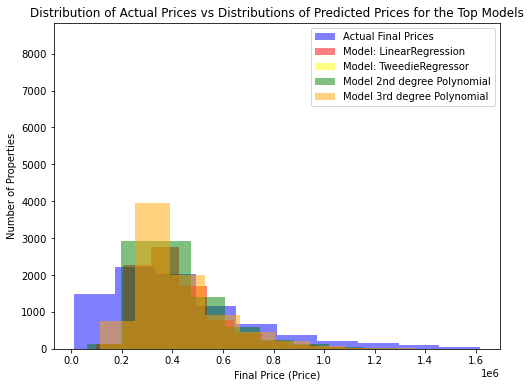

In [108]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(8,6))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Final Prices")
plt.hist(y_validate.price_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.price_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.price_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.hist(y_validate.price_pred_lm3, color='orange', alpha=.5, label="Model 3rd degree Polynomial")
plt.xlabel("Final Price (Price)")
plt.ylabel("Number of Properties")
plt.title("Distribution of Actual Prices vs Distributions of Predicted Prices for the Top Models")
plt.legend()
plt.show()

In [109]:
# Comparing models DF:

In [110]:
metric_df

model  RMSE_validate  r^2_validate
0    median_baseline   2.890241e+05  0.000000e+00
1      OLS Regressor   2.356024e+05  3.229942e-01
2      lasso_alpha_1   2.356036e+05  3.229875e-01
3          quadratic   2.310842e+05  3.485960e-01
4  3degree_quadratic   2.282231e+05  3.645728e-01
5  4degree_quadratic   1.232019e+14 -1.852354e+17

# Run Model on Test Sample
**Model Selection & Out-of-Sample Evaluation**

Model selected: Polynomial Regression (using LinearRegression)

In [111]:
# predict test
y_test['price_pred_lm3'] = lm3.predict(X_test_degree3)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.price_pred_lm3) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nTest/Out-of-Sample: ", rmse_test)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  222469.24045964127 
Validation/Out-of-Sample:  123201898964089.2 
Test/Out-of-Sample:  227205.0268785899


In [112]:
metric_df = make_metric_df(y_test.tax_value,
               y_test.price_pred_lm3,
               'TEST_quadratic',
               metric_df)
metric_df

model  RMSE_validate  r^2_validate
0    median_baseline   2.890241e+05  0.000000e+00
1      OLS Regressor   2.356024e+05  3.229942e-01
2      lasso_alpha_1   2.356036e+05  3.229875e-01
3          quadratic   2.310842e+05  3.485960e-01
4  3degree_quadratic   2.282231e+05  3.645728e-01
5  4degree_quadratic   1.232019e+14 -1.852354e+17
6     TEST_quadratic   2.272050e+05  3.560611e-01

In [113]:
metric_df.style.format(
                formatter={('RMSE_validate', 'r^2_validate'): "{:.2f}",
                          })

### Modeling Takeaways:

- Polynomial Regression Model performed better than the baseline by having a lower RMSE than the baseline
- The model had a difference of over $60,000 compared to the baseline
- The model explained 35.6% of the variance on out of sample data very similar to our validate dataset. 

***

## Getting State & County Info for Each Property and Tax Rates for Each County

Zach lost the email that told us where these properties were located. Ugh, Zach :-/. Because property taxes are assessed at the county level, we would like to know what states and counties these are located in.

We'd also like to know the distribution of tax rates for each county.

The data should have the tax amounts and tax value of the home, so it shouldn't be too hard to calculate. Please include in your report to us the distribution of tax rates for each county so that we can see how much they vary within the properties in the county and the rates the bulk of the properties sit around.

Note that this is separate from the model you will build, because if you use tax amount in your model, you would be using a future data point to predict a future data point, and that is cheating! In other words, for prediction purposes, we won't know tax amount until we know tax value.

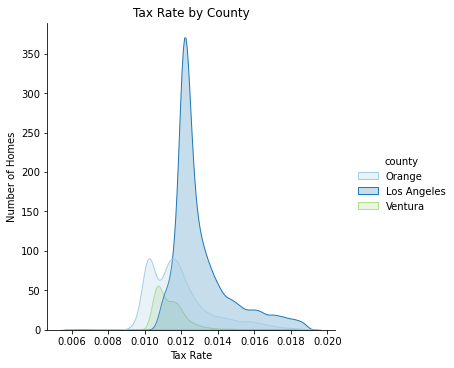

In [114]:
#Plotting distribution of tax rate by county

sns.displot(df, x='tax_rate', hue='county', kind='kde', fill=True)
plt.title('Tax Rate by County')
plt.ylabel('Number of Homes')
plt.xlabel('Tax Rate')
plt.show()

In [115]:
df.tax_rate.max()


0.018851624916101935

In [116]:
df.loc[df['tax_rate'] == df.tax_rate.max()]

bedrooms  bathrooms  sq_footage  tax_value  yr_built  taxamount  \
22868       3.0        1.5      1276.0    46187.0    1964.0      870.7   

         fips  propertylandusetypeid        propertylandusedesc  tax_rate  \
22868  6059.0                  261.0  Single Family Residential  0.018852   

       county       state  
22868  Orange  California

In [117]:
df.tax_rate.min()

0.0062223923670416395

In [118]:
df.loc[df['tax_rate'] == df.tax_rate.min()]

bedrooms  bathrooms  sq_footage  tax_value  yr_built  taxamount    fips  \
9225       3.0        2.5      1250.0   237706.0    1998.0     1479.1  6059.0   

      propertylandusetypeid propertylandusedesc  tax_rate  county       state  
9225                  266.0         Condominium  0.006222  Orange  California

In [119]:
df.tax_rate.mean()

0.012574975783964038

In [120]:
df.groupby('county').tax_rate.mean()

county
Los Angeles    0.013054
Orange         0.011912
Ventura        0.011513
Name: tax_rate, dtype: float64

In [121]:
df.groupby('county').fips.count()

county
Los Angeles    21469
Orange         10420
Ventura         3189
Name: fips, dtype: int64

In [122]:
df.county.value_counts()

Los Angeles    21469
Orange         10420
Ventura         3189
Name: county, dtype: int64

### Location & Tax Rates Takeaways

- All properties are located in the state of California
- All properties are located in one of 3 counties:
    - Los Angeles County
    - Orange County
    - Ventura County
    
    
- The max tax rate was 0.01885 was located in Orange County
- The mix tax rate was 0.00622 was located in Orange County
- The highest average tax rate was in Los Angeles County with an average of 0.013054
- The lowest average tax rate was Ventura County with an average of  0.011513
- The highest number of properties were located in Los Angeles County with 21,469 properties
- The lowest number of properties were located in Ventura County with 3,189 properties
